In [1]:
import datetime
import functools
import gc
import os
import random
from bisect import bisect_right
from time import time

import numpy as np
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from mpl_toolkits import axes_grid1

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_datasets as tfds

In [3]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except ModuleNotFoundError:
    !pip install tfsim-nightly
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [4]:
tfsim.utils.tf_cap_memory()  # Avoid GPU memory blow up

Physical devices cannot be modified after being initialized


In [5]:
# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

In [6]:
ds, data_info = tfds.load("caltech_birds2011", split="all", with_info=True, as_supervised=True)
# num_examples_train = data_info.splits["train"].num_examples
# num_examples_test = data_info.splits["test"].num_examples
total_num_classes = data_info.features["label"].num_classes

In [7]:
# from PIL import Image
# import torchvision.transforms as T

# for img, y in ds.take(2).as_numpy_iterator():
#     img = Image.fromarray(img)
#     img = T.Resize(size=256)(img)
#     #plt.imshow(img)
#     img = T.RandomResizedCrop(scale=(0.16, 1.), size=227)(img)
#     plt.imshow(img)
#     # print(np.asarray(img))

In [8]:
training_classes = total_num_classes // 1
examples_per_class_per_batch = 5

batch_size = 80
classes_per_batch = batch_size // examples_per_class_per_batch  # 16 classes per batch
origin_img_size = 256
target_img_size = 227
area_range = [0.16, 1.0]
# # preprocessing function that resizes images to ensure all images are the same shape
# pxl_mean = tf.constant(-np.array([0.40784313725490196, 0.4588235294117647, 0.5019607843137255]), dtype=tf.float32)
# pxl_std = tf.constant(np.array([0.00392156862745098, 0.00392156862745098, 0.00392156862745098]), dtype=tf.float32)

train_cls = list(range(100))
test_cls = list(range(100, 199))

print(f"Class IDs seen during training {train_cls}")


def torchvision_resize(img, origin_size):
    img_shape = tf.shape(img)
    aspect_ratio = img_shape[0] / img_shape[1]
    if img_shape[0] < img_shape[1]:
        height = origin_size
        width = tf.cast(tf.cast(img_shape[1], dtype=tf.float64) * (img_shape[0] / origin_size), dtype=tf.int32)
    else:
        height = tf.cast(tf.cast(img_shape[0], dtype=tf.float64) * (img_shape[1] / origin_size), dtype=tf.int32)
        width = origin_size
    return tf.image.resize(img, [height, width], preserve_aspect_ratio=True)


def preprocess(img, y, *args, origin_size):
    with tf.device("/cpu:0"):
        img = torchvision_resize(img, origin_size)
        img = tf.keras.applications.resnet50.preprocess_input(img)
        # # 'RGB'->'BGR'
        # img = img[..., ::-1]
        # Reverse the mean and std vals as we are using RGB instead.
        # normalize_transform
        # img /= 255.0
        # img = tf.nn.bias_add(img, pxl_mean, data_format=None)
        # img /= pxl_std

    return img, y


def train_augmentation(img_batch, y, *args, target_size, area_range):
    # create random crops
    # num_imgs = tf.shape(img_batch)[0]
    aug_imgs = []
    for img in img_batch:
        crop_area = tf.random.uniform(shape=(1, 1), minval=0.15, maxval=1.0)
        start_y = tf.random.uniform(shape=(1, 1), minval=0.0, maxval=1 - crop_area)
        start_x = tf.random.uniform(shape=(1, 1), minval=0.0, maxval=1 - crop_area)
        start_yx = tf.concat((start_y, start_x), axis=1)
        end_yx = start_yx + crop_area
        boxes = tf.concat((start_yx, end_yx), axis=1)
        box_indicies = tf.range(1)

        # random crop
        img = tf.image.crop_and_resize(tf.expand_dims(img, axis=0), boxes, box_indicies, (target_size, target_size))
        # random horizontal flip
        img = tf.image.random_flip_left_right(img)
        aug_imgs.append(img[0])

    return tf.convert_to_tensor(np.array(aug_imgs)), y


def test_augmentation(img_batch, y, *args, origin_size, target_size):
    aug_imgs = []
    for img in img_batch:
        img = tf.image.central_crop(img, target_size / origin_size)
        img = tf.keras.layers.Resizing(target_size, target_size, crop_to_aspect_ratio=True)(img)
        aug_imgs.append(img)

    return tf.convert_to_tensor(np.array(aug_imgs)), y


ds = ds.map(lambda x, y: preprocess(x, y, origin_size=origin_img_size))
train_ds = tuple(zip(*tfds.as_numpy(ds.filter(lambda x, y: tf.math.reduce_any(tf.equal(y, train_cls))))))
test_ds = tuple(zip(*tfds.as_numpy(ds.filter(lambda x, y: tf.math.reduce_any(tf.equal(y, test_cls))))))

train_x = train_ds[0]
train_y = train_ds[1]

test_x = test_ds[0]
test_y = test_ds[1]

# use the train split for training
train_ds = tfsim.samplers.memory_samplers.RaggedMultiShotMemorySampler(
    x=train_x,
    y=train_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    class_list=train_cls,
    augmenter=functools.partial(
        train_augmentation,
        target_size=target_img_size,
        area_range=area_range,
    ),
)  # We filter train data to only keep the train classes.

# use the test split for indexing and querying
test_ds = tfsim.samplers.memory_samplers.RaggedMultiShotMemorySampler(
    x=test_x,
    y=test_y,
    examples_per_class_per_batch=examples_per_class_per_batch,
    classes_per_batch=classes_per_batch,
    augmenter=functools.partial(
        test_augmentation,
        origin_size=origin_img_size,
        target_size=target_img_size,
    ),
)


# # use the train split for training
# train_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
#     "cars196",
#     splits="all",
#     examples_per_class_per_batch=examples_per_class_per_batch,
#     classes_per_batch=classes_per_batch,
#     preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
#     class_list=train_cls,
#     augmenter=functools.partial(
#         train_augmentation,
#         target_size=target_img_size,
#         area_range=area_range,
#     ),
# )  # We filter train data to only keep the train classes.

# # use the test split for indexing and querying
# test_ds = tfsim.samplers.TFDatasetMultiShotMemorySampler(
#     "cars196",
#     splits="all",
#     examples_per_class_per_batch=examples_per_class_per_batch,
#     classes_per_batch=classes_per_batch,
#     preprocess_fn=functools.partial(preprocess, origin_size=origin_img_size),
#     class_list=test_cls,
#     augmenter=functools.partial(
#         test_augmentation,
#         origin_size=origin_img_size,
#         target_size=target_img_size,
#     ),
# )

num_examples_train = len(train_ds._y)
num_examples_test = len(test_ds._y)

Class IDs seen during training [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/5864 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/100 [00:00<?, ?it/s]

gather examples:   0%|          | 0/5864 [00:00<?, ?it/s]

/home/jupyter/Workspace/similarity/tensorflow_similarity/samplers/utils.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(batch_x), np.array(batch_y)


indexing classes:   0%|          | 0/5864 [00:00<?, ?it/s]


The initial batch size is 80 (16 classes * 5 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/5864 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/99 [00:00<?, ?it/s]

gather examples:   0%|          | 0/5864 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/5864 [00:00<?, ?it/s]

In [9]:
# num_cols = num_rows = 5
# # Get the first 25 examples.
# x_slice, y_slice = train_ds.get_slice(begin=0, size=num_cols * num_rows)

# x_min = tf.math.reduce_min(x_slice)
# x_max = tf.math.reduce_max(x_slice)

# fig = plt.figure(figsize=(10.0, 10.0))
# grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# # NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
# for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
#     ax.imshow(im)
#     ax.axis("off")

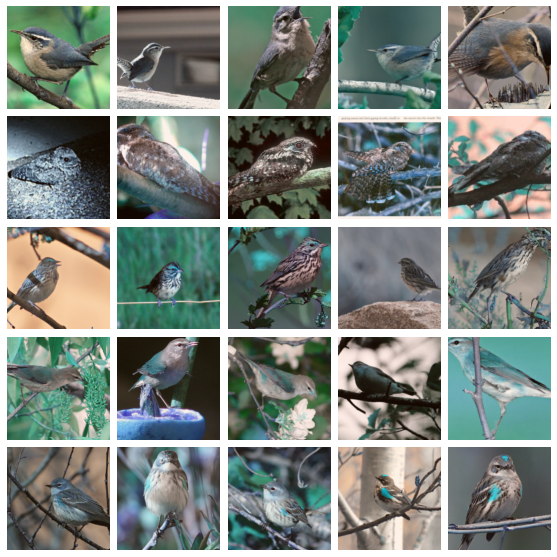

In [10]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = test_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

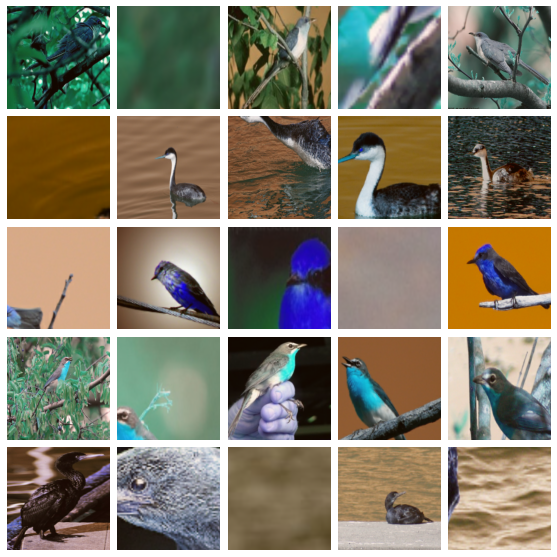

In [11]:
num_cols = num_rows = 5
# Get the first 25 examples.
(x_batch, y_batch) = train_ds.generate_batch(0)
x_slice = x_batch[0 : num_cols * num_rows]
y_slice = y_batch[0 : num_cols * num_rows]

x_min = tf.math.reduce_min(x_slice)
x_max = tf.math.reduce_max(x_slice)

fig = plt.figure(figsize=(10.0, 10.0))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

# NOTE: the colors will be off because the resnet preprocessing rotates the color channels.
for ax, im, label in zip(grid, (x_slice - x_min) / (x_max - x_min), y_slice):
    ax.imshow(im)
    ax.axis("off")

In [12]:
def generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, class_list):
    q_x, q_y = [], []
    i_x, i_y = [], []

    # get example for each class
    q_idxs = []
    i_idxs = []
    total_samples = num_queries_per_class + num_index_per_class
    for class_id in class_list:
        class_idxs = test_ds.index_per_class[class_id]
        if len(class_idxs) < total_samples:
            print(
                f"warning: Class {class_id} only has {len(class_idxs)} examples but "
                f"{total_samples} were requested. Using choices instead of sample."
            )
            sampled_idxs = random.choices(class_idxs, k=total_samples)
        else:
            sampled_idxs = random.sample(class_idxs, k=total_samples)

        q_idxs.extend(sampled_idxs[:num_queries_per_class])
        i_idxs.extend(sampled_idxs[num_queries_per_class:])

    # strip examples if needed. This might happen due to rounding
    for idx in q_idxs:
        q_x.append(test_ds._x[idx])
        q_y.append(test_ds._y[idx])

    for idx in i_idxs:
        i_x.append(test_ds._x[idx])
        i_y.append(test_ds._y[idx])

    return (
        np.array(q_x),
        np.array(q_y),
        np.array(i_x),
        np.array(i_y),
    )

In [33]:
num_queries_per_class = 3
num_index_per_class = 10
k = 1

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)

# Setup SplitValidation callback.
val_loss = tfsim.callbacks.EvalCallback(
    queries_x,
    tf.cast(queries_y, dtype=tf.dtypes.int32),
    targets_x,
    tf.cast(targets_y, dtype=tf.dtypes.int32),
    metrics=["f1", "binary_accuracy"],
    # known_classes=tf.constant(train_cls),
    k=k,
)

logdir = os.path.join("logs_cars", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)
tbc = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    val_loss,
    tbc,
]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


logs_cars/20220428-234137


In [34]:
# building model
model = tfsim.architectures.ResNet50Sim(
    input_shape=(target_img_size, target_img_size, 3),
    embedding_size=512,
    weights = "imagenet",
    trainable="full",
    include_top=True,
    l2_norm=True,
    pooling='avg',
)

In [35]:
for layer in model.layers:
    if layer.name == "resnet50":
        for rl in layer.layers:
            print(f"{rl.name} | {rl.trainable} | weights: {len(rl.weights)} | trainable_weights: {len(rl.trainable_weights)} | non_trainable_weights: {len(rl.non_trainable_weights)}")
    else: 
        print(f"{layer.name} | {layer.trainable} | weights: {len(layer.weights)} | trainable_weights: {len(layer.trainable_weights)} | non_trainable_weights: {len(layer.non_trainable_weights)}")

input_7 | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
input_8 | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
conv1_pad | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
conv1_conv | True | weights: 2 | trainable_weights: 2 | non_trainable_weights: 0
conv1_bn | False | weights: 4 | trainable_weights: 0 | non_trainable_weights: 4
conv1_relu | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
pool1_pad | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
pool1_pool | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
conv2_block1_1_conv | True | weights: 2 | trainable_weights: 2 | non_trainable_weights: 0
conv2_block1_1_bn | False | weights: 4 | trainable_weights: 0 | non_trainable_weights: 4
conv2_block1_1_relu | True | weights: 0 | trainable_weights: 0 | non_trainable_weights: 0
conv2_block1_2_conv | True | weights: 2 | trainable_weights: 2 | non_trainable_weights: 0
co

In [36]:
# # Inception model
# inputs = tf.keras.layers.Input(shape=(target_img_size, target_img_size, 3))
# x = inputs
# x = tf.keras.applications.inception_v3.InceptionV3(
#     include_top=False,
#     weights='imagenet',
#     pooling='avg')(x)
# outputs = tfsim.layers.MetricEmbedding(embedding_size)(x)
# model = tfsim.models.SimilarityModel(inputs, outputs)

In [38]:
lr_mul = 0.1
LR = 3e-5
WD = 0.0005
steps_per_epoch = 20  # num_examples_train // batch_size
epochs = 3000 // steps_per_epoch
validation_steps = num_examples_test // batch_size
steps_decay = [1200, 2400]

# init similarity loss
distance = "cosine"
loss = tfsim.losses.MultiSimilarityLoss(distance=distance, alpha=2.0, beta=40.0, epsilon=0.1, lmda=0.5, center=1.0)

# step = tf.Variable(0, trainable=False)
lr_milestones = [3e-05, 3e-06, 3e-07]
lr_schedule = tf.optimizers.schedules.PiecewiseConstantDecay(steps_decay, lr_milestones)
# lr = LR * lr_schedule(step)
# wd = lambda: WD * lr_schedule(step)

# optimizer = tfa.optimizers.AdamW(
#     weight_decay=WD,
#     learning_rate=lr,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-08,
# )
# optimizer = tfa.optimizers.LAMB(
#     learning_rate=lr,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-08,  
#     weight_decay_rate=WD,
#     exclude_from_weight_decay=['bn'],
# )
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
)


# compiling and training
model.compile(optimizer=optimizer, loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [30]:
num_queries_per_class = 10
num_index_per_class = 32

# Setup EvalCallback by splitting the test data into targets and queries.
queries_x, queries_y, targets_x, targets_y = generate_eval_data(test_ds, num_queries_per_class, num_index_per_class, test_cls)

queries_x, queries_y = test_augmentation(
    queries_x,
    queries_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)
targets_x, targets_y = test_augmentation(
    targets_x,
    targets_y,
    origin_size=origin_img_size,
    target_size=target_img_size,
)


model.reset_index()
model.index(targets_x, targets_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[Indexing 3168 points]
|-Computing embeddings
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [31]:
calibration_results = model.calibrate(queries_x, queries_y)


Performing NN search



Building NN list:   0%|          | 0/990 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/989 [00:00<?, ?it/s]


 name       value    distance    precision    recall        f1
-------  -------  ----------  -----------  --------  --------
optimal     0.73    0.427849     0.572727         1  0.728324


In [32]:
recall_metrics = [tfsim.retrieval_metrics.RecallAtK(k=i) for i in (1, 2, 4, 8, 16, 32)]
prec_metrics = [tfsim.retrieval_metrics.PrecisionAtK(k=i) for i in (1, 2, 4, 8, 16, 32)]
dist_thresh = np.round(calibration_results.cutpoints["optimal"]["distance"], 4)
bndcg_metrics = [tfsim.retrieval_metrics.BNDCG(k=i, distance_threshold=dist_thresh) for i in (1, 2, 4, 8, 16, 32)]

model.evaluate_retrieval(queries_x, queries_y, recall_metrics + prec_metrics + bndcg_metrics);

|-Computing embeddings
|-Computing retrieval metrics

Performing NN search



Building NN list:   0%|          | 0/990 [00:00<?, ?it/s]


 [Summary]

metric                                  Value
-----------------------------------  --------
recall@1                             0.572727
recall@2                             0.690909
recall@4                             0.794949
recall@8                             0.876768
recall@16                            0.926263
recall@32                            0.961616
precision@1                          0.572727
precision@2                          0.540404
precision@4                          0.514141
precision@8                          0.473232
precision@16                         0.41452
precision@32                         0.330934
ndcg@1 : distance_threshold@0.4278   0.571717
ndcg@2 : distance_threshold@0.4278   0.646282
ndcg@4 : distance_threshold@0.4278   0.689126
ndcg@8 : distance_threshold@0.4278   0.706644
ndcg@16 : distance_threshold@0.4278  0.707706
ndcg@32 : distance_threshold@0.4278  0.702301
